In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
ACCESS_KEY = "ne79Uc3eEnPuGSkxk4kD"
SECRET_KEY = "5P25NoGliHTu2SfW48EcahhOWUYWldOUZ2T6bmtA"
MINIO_URL = "http://minio:9000"

spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("HW2") \
    .config("spark.sql.adaptive.enabled", False) \
    .config("spark.sql.autoBroadcastJoinThreshold", -1) \
    .config("spark.sql.sources.bucketing.enabled", True) \
    .config("spark.executor.memory", "450M") \
    .config("spark.driver.memory", "450M") \
    .config('spark.jars.packages', 
        "org.apache.hadoop:hadoop-aws:3.3.2,com.amazonaws:aws-java-sdk-pom:1.12.365,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.1"
    ) \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider') \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.access.key", ACCESS_KEY) \
    .config("spark.hadoop.fs.s3a.secret.key", SECRET_KEY) \
    .config("spark.hadoop.fs.s3a.endpoint", MINIO_URL) \
    .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-0142c883-e496-48fb-b90b-dbfd7192a5c5;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.1026 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found com.amazonaws#aws-java-sdk-pom;1.12.365 in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.1 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.1 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.3 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#ha

# Задание 1

## Входные данные 
- Файл с данными по оттоку телеком оператора в США (churn.csv)
- Справочник с названиями штатов (state.json)
- Справочник с численностью населения территорий (определяется полем area code) внутри штатов (state.json)
- Террия с численностью населения меньше 10_000 считается **мелкой**

## Что нужно сделать
1. Посчитать количество отточных и неотточных абонентов (поле churn), исключив **мелкие** территории
2. Отчет должен быть выполнен в разрезе **каждого штата** с его полным наименованием
3. Описать возникающие узкие места при выполнении данной операции
4. Применить один из способов оптимизации для ускорения выполнения запроса (при допущении, что справочник численности населения **сильно меньше** основных данных)
5. Если существует еще какой-то способ, применить также и его отдельно от п.4 (при допущении, что справочник численности населения **сопоставим по размеру** с основными данными)
6. Кратко описать реализованные способы и в чем их практическая польза

- P.S. Одним из выбранных способов должен быть Bucket specific join
- P.P.S. При обосновании предлагаем прикладывать запуска команды df.explain()

In [3]:
spark

In [4]:
churn_df = spark.read.option("header", True).csv("s3a://input/churn.csv")
state_dict = spark.read.json("s3a://input/state.json")
pop_dict = spark.read.json("s3a://input/population.json")

24/06/27 17:46:13 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


### Решение

In [5]:
churn_df.show(2, vertical=True)

-RECORD 0--------------------------
 id                     | 22       
 state                  | AK       
 account length         | 173      
 area code              | 131      
 phone number           | 349-9060 
 international plan     | no       
 voice mail plan        | no       
 number vmail messages  | 0        
 total day minutes      | 172.5    
 total day calls        | 78       
 total day charge       | 29.33    
 total eve minutes      | 142.6    
 total eve calls        | 91       
 total eve charge       | 12.12    
 total night minutes    | 102.0    
 total night calls      | 63       
 total night charge     | 4.59     
 total intl minutes     | 10.9     
 total intl calls       | 2        
 total intl charge      | 2.94     
 customer service calls | 0        
 churn                  | False    
 val                    | 131      
-RECORD 1--------------------------
 id                     | 23       
 state                  | AK       
 account length         | 12

In [6]:
state_dict.show(2, vertical=True)

-RECORD 0-------------
 state_id   | AL      
 state_name | Alabama 
-RECORD 1-------------
 state_id   | AK      
 state_name | Alaska  
only showing top 2 rows



In [7]:
pop_dict.show(2, vertical=True)

-RECORD 0-----------
 area code  | 131   
 population | 15742 
-RECORD 1-----------
 area code  | 139   
 population | 20233 
only showing top 2 rows



In [8]:
result = churn_df.join(pop_dict , on='area code', how='left') \
    .filter(pop_dict['population'] > 10000)

result = result.join(state_dict, state_dict['state_id'] == result['state'], how='left')

result = result.groupby('state_name', 'churn') \
    .count() \
    .orderBy('state_name')


In [9]:
# Здесь необходимо вывести результат:
result.explain()
result.show(truncate=False)

== Physical Plan ==
*(11) Sort [state_name#72 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(state_name#72 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=181]
   +- *(10) HashAggregate(keys=[state_name#72, churn#38], functions=[count(1)])
      +- Exchange hashpartitioning(state_name#72, churn#38, 200), ENSURE_REQUIREMENTS, [plan_id=177]
         +- *(9) HashAggregate(keys=[state_name#72, churn#38], functions=[partial_count(1)])
            +- *(9) Project [churn#38, state_name#72]
               +- *(9) SortMergeJoin [state#18], [state_id#71], LeftOuter
                  :- *(6) Sort [state#18 ASC NULLS FIRST], false, 0
                  :  +- Exchange hashpartitioning(state#18, 200), ENSURE_REQUIREMENTS, [plan_id=160]
                  :     +- *(5) Project [state#18, churn#38]
                  :        +- *(5) SortMergeJoin [cast(area code#20 as bigint)], [area code#83L], Inner
                  :           :- *(2) Sort [cast(area code#20 as bigint) ASC NULLS FIRST],

+--------------------+-----+-----+
|state_name          |churn|count|
+--------------------+-----+-----+
|Alabama             |False|58   |
|Alabama             |True |7    |
|Alaska              |True |3    |
|Alaska              |False|44   |
|Arizona             |True |4    |
|Arizona             |False|53   |
|Arkansas            |True |9    |
|Arkansas            |False|35   |
|California          |False|21   |
|California          |True |8    |
|Colorado            |True |7    |
|Colorado            |False|49   |
|Connecticut         |True |8    |
|Connecticut         |False|56   |
|Delaware            |True |8    |
|Delaware            |False|48   |
|District of Columbia|True |4    |
|District of Columbia|False|43   |
|Florida             |True |8    |
|Florida             |False|45   |
+--------------------+-----+-----+
only showing top 20 rows



### Оптимизация 1

Для случая, когда справочник численности населения значительно меньше основных данных можно использовать Broadcast Join

In [10]:
result = churn_df.join(F.broadcast(pop_dict) , on='area code', how='left') \
    .filter(pop_dict['population'] > 10000)

result = result.join(state_dict, state_dict['state_id'] == result['state'], how='left')

result = result.groupby('state_name', 'churn') \
    .count() \
    .orderBy('state_name')


In [11]:
# Здесь необходимо вывести результат:
result.explain()
result.show(truncate=False)

== Physical Plan ==
*(8) Sort [state_name#72 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(state_name#72 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=534]
   +- *(7) HashAggregate(keys=[state_name#72, churn#38], functions=[count(1)])
      +- Exchange hashpartitioning(state_name#72, churn#38, 200), ENSURE_REQUIREMENTS, [plan_id=530]
         +- *(6) HashAggregate(keys=[state_name#72, churn#38], functions=[partial_count(1)])
            +- *(6) Project [churn#38, state_name#72]
               +- *(6) SortMergeJoin [state#18], [state_id#71], LeftOuter
                  :- *(3) Sort [state#18 ASC NULLS FIRST], false, 0
                  :  +- Exchange hashpartitioning(state#18, 200), ENSURE_REQUIREMENTS, [plan_id=513]
                  :     +- *(2) Project [state#18, churn#38]
                  :        +- *(2) BroadcastHashJoin [cast(area code#20 as bigint)], [area code#83L], Inner, BuildRight, false
                  :           :- *(2) Filter isnotnull(area code#20)


+--------------------+-----+-----+
|state_name          |churn|count|
+--------------------+-----+-----+
|Alabama             |False|58   |
|Alabama             |True |7    |
|Alaska              |True |3    |
|Alaska              |False|44   |
|Arizona             |True |4    |
|Arizona             |False|53   |
|Arkansas            |True |9    |
|Arkansas            |False|35   |
|California          |False|21   |
|California          |True |8    |
|Colorado            |True |7    |
|Colorado            |False|49   |
|Connecticut         |True |8    |
|Connecticut         |False|56   |
|Delaware            |True |8    |
|Delaware            |False|48   |
|District of Columbia|True |4    |
|District of Columbia|False|43   |
|Florida             |True |8    |
|Florida             |False|45   |
+--------------------+-----+-----+
only showing top 20 rows




| Broadcast Join               | SortMerge Join               |
| ---------------------- | ---------------------- |
| 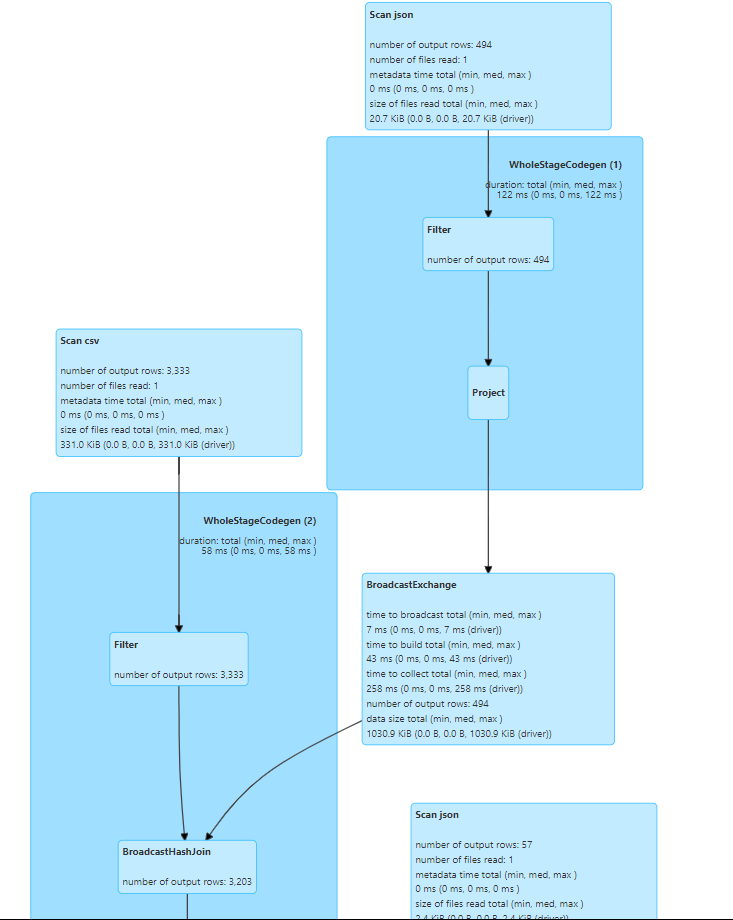 | 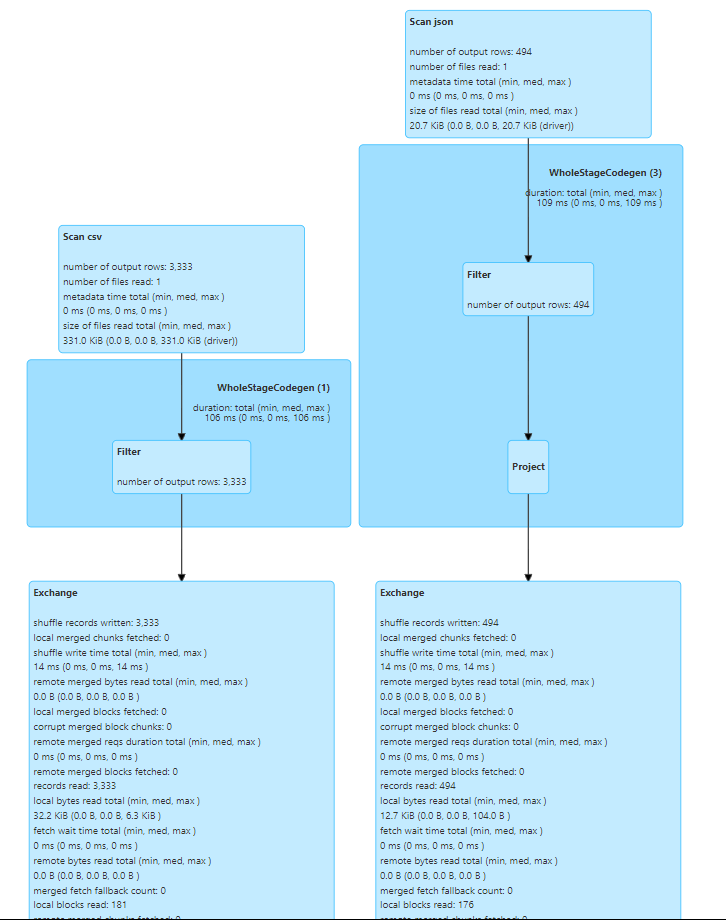 |

### Оптимизация 2

In [12]:
# num_buckets = 2

# churn_df.write.bucketBy(num_buckets, 'state').sortBy('id').mode('overwrite').saveAsTable('bucketed_churn', format='csv')
# pop_dict.write.bucketBy(num_buckets, 'area code').sortBy('population').mode('overwrite').saveAsTable('bucketed_population', format='csv')

# bucketed_churn_df = spark.table('bucketed_churn')
# bucketed_population_df = spark.table('bucketed_population')

# # Выполнение bucket specific join
# bucketed_join_df = bucketed_churn_df.join(bucketed_population_df, 'area code')
# bucketed_join_state_df = bucketed_join_df.join(state_df, bucketed_join_df['state'] == state_df['state_code'])


In [13]:
# Здесь необходимо вывести результат:
# result.show(truncate=False)

# Задание 2

## Входные данные 

*skew_transactions.csv* - информация о длительности просомтра контента пользователям
колонки:
1. user_uid — уникальный идентификатор пользователя
2. element_uid — уникальный идентификатор контента
3. watched_time — время просмотра в секундах

*catalogue.json* - каталог с описанием контента и метаинформации по нему
колонки:
1. type — тип элемента
2. duration — длительность в минутах (средняя длительность эпизода в случае с сериалами и многосерийными фильмами), округлённая до десятков
3. attributes — анонимизированные атрибуты данного элемента
4. availability — доступные права на элемент(subscription, purchase, rent)
5. feature_1 — анонимизированная вещественная переменная
6. feature_2 — анонимизированная вещественная переменная
7. feature_3 — анонимизированная порядковая переменная
8. feature_4 — анонимизированная вещественная переменная
9. feature_5 — анонимизированная вещественная переменная

## Что нужно сделать
1. Выполните join основных данных со справочником используя DataFrame API (по колонке id для контента - `element_uid`)
2. Описать проблему в датасетах с точки зрения обработки Spark
3. Решить задачу любым способом
4. Решить задачу с помощью salt-join подхода

P.S. Как вы можете заметить при просмотре данных по пользователями, нужный нам ключ для операции будет перекошен (90% строк представлены на фильм, очень популярный среди смотревших) - это нужно доказать в рамках п.2

In [14]:
import pandas as pd
import s3fs

In [15]:
transactions_df = spark.read.option('header', True).csv('s3a://input/skew_transactions.csv')

s3 = s3fs.S3FileSystem(client_kwargs={
    'endpoint_url': MINIO_URL,
    'aws_access_key_id': ACCESS_KEY,
    'aws_secret_access_key': SECRET_KEY
})


# Чтение JSON файла с использованием pandas
catalogue_pd = pd.read_json('s3a://input/catalogue.json', orient='str', storage_options={
    'client_kwargs': {
        'endpoint_url': MINIO_URL,
        'aws_access_key_id': ACCESS_KEY,
        'aws_secret_access_key': SECRET_KEY
    }
}).T.reset_index()

for column in catalogue_pd.columns:
    if catalogue_pd[column].dtype == 'int64':
        catalogue_pd[column] = catalogue_pd[column].astype('float64')
    elif catalogue_pd[column].dtype == 'float64':
        catalogue_pd[column] = catalogue_pd[column].astype('float64')
    elif catalogue_pd[column].dtype == 'object':
        catalogue_pd[column] = catalogue_pd[column].astype('str')

catalogue = spark.createDataFrame(catalogue_pd)

In [16]:
transactions_df.show(3, truncate=True)

+-----------+--------+------------+
|element_uid|user_uid|watched_time|
+-----------+--------+------------+
|       6130|  563180|        3264|
|       2771|  133315|       10557|
|        984|  290104|        6845|
+-----------+--------+------------+
only showing top 3 rows



In [17]:
catalogue.show(3, truncate=True)

24/06/27 17:46:48 WARN TaskSetManager: Stage 19 contains a task of very large size (1066 KiB). The maximum recommended task size is 1000 KiB.


+------+-----+--------------------+--------+------------------+------------------+---------+------------+------------+--------------------+
| index| type|        availability|duration|         feature_1|         feature_2|feature_3|   feature_4|   feature_5|          attributes|
+------+-----+--------------------+--------+------------------+------------------+---------+------------+------------+--------------------+
|1983.0|movie|['purchase', 'ren...|     140| 1657223.396513469|      0.7536096584|       39|1.1194091265|         0.0|[1, 2, 3, 4, 5, 6...|
|3783.0|movie|['purchase', 'ren...|     110|35565207.694893226|      0.7662537759|       41|1.1386044027|0.6547073468|[1, 26, 27, 28, 2...|
|5208.0|movie|['purchase', 'ren...|      90| 13270676.52431015|0.7654246597000001|       27|1.1318073548|0.5927161087|[1, 38, 39, 40, 7...|
+------+-----+--------------------+--------+------------------+------------------+---------+------------+------------+--------------------+
only showing top 3 r

### Описание проблемы в датасетах с точки зрения обработки Spark

Основная проблема в данных заключается в перекосе (skew) ключа element_uid, где 90% строк представлены на один элемент контента. Это создает дисбаланс в распределении данных между исполнителями в Spark, что может привести к снижению производительности обработки данных.

In [18]:
skew_check_df = transactions_df.groupBy("element_uid").agg(F.count("user_uid").alias("count")).orderBy(F.col("count").desc())

# Вывод результатов
skew_check_df.show(10)

+-----------+-------+
|element_uid|  count|
+-----------+-------+
|       2714|2732800|
|        747|  61272|
|      10170|    299|
|       9898|    299|
|       9837|    299|
|       3469|    299|
|       8763|    299|
|       6796|    298|
|       4107|    298|
|       9108|    298|
+-----------+-------+
only showing top 10 rows



### Решение 

In [19]:
result = transactions_df.join(catalogue, transactions_df['element_uid'] == catalogue['index'], how='inner') \
    .orderBy('element_uid', 'user_uid')

In [20]:
# Здесь необходимо вывести результат:
result.explain()
result.show(truncate=False)

== Physical Plan ==
*(6) Sort [element_uid#503 ASC NULLS FIRST, user_uid#504 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(element_uid#503 ASC NULLS FIRST, user_uid#504 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=865]
   +- *(5) SortMergeJoin [knownfloatingpointnormalized(normalizenanandzero(cast(element_uid#503 as double)))], [knownfloatingpointnormalized(normalizenanandzero(index#509))], Inner
      :- *(2) Sort [knownfloatingpointnormalized(normalizenanandzero(cast(element_uid#503 as double))) ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(knownfloatingpointnormalized(normalizenanandzero(cast(element_uid#503 as double))), 200), ENSURE_REQUIREMENTS, [plan_id=852]
      :     +- *(1) Filter isnotnull(element_uid#503)
      :        +- FileScan csv [element_uid#503,user_uid#504,watched_time#505] Batched: false, DataFilters: [isnotnull(element_uid#503)], Format: CSV, Location: InMemoryFileIndex(1 paths)[s3a://input/skew_transactions.csv], PartitionFi

24/06/27 17:46:54 WARN TaskSetManager: Stage 22 contains a task of very large size (1065 KiB). The maximum recommended task size is 1000 KiB.


+-----------+--------+------------+-------+-----+--------------------+--------+-----------------+-----------+---------+------------+------------+--------------------------------------------------------------------------------+
|element_uid|user_uid|watched_time|index  |type |availability        |duration|feature_1        |feature_2  |feature_3|feature_4   |feature_5   |attributes                                                                      |
+-----------+--------+------------+-------+-----+--------------------+--------+-----------------+-----------+---------+------------+------------+--------------------------------------------------------------------------------+
|10005      |103945  |4629        |10005.0|movie|['purchase', 'rent']|80      |9884585.371386299|0.777261912|7        |1.1265750641|0.5927161087|[73, 1231, 2297, 2308, 2298, 7, 52, 41, 11, 17, 18, 19, 20, 45, 2307, 1745, 165]|
|10005      |104436  |4830        |10005.0|movie|['purchase', 'rent']|80      |9884585.37138

### Решение с оптимизацией

In [21]:
# Добавление salt к каждому элементу
salted_transactions_df = transactions_df.withColumn('salt', (F.floor(F.rand() * 10)).cast('int'))

salt_values_df = spark.createDataFrame([(i,) for i in range(10)], ['salt'])

# Добавление всех значений соли к catalogue_dict
salted_catalogue = catalogue.crossJoin(salt_values_df)

for i in range(10):
    salted_catalogue = salted_catalogue.union(catalogue.withColumn('salt', F.lit(i)))

# Выполнение salted join
result = salted_transactions_df.join(salted_catalogue, 
                                                (salted_transactions_df.element_uid == salted_catalogue.index) & 
                                                (salted_transactions_df.salt == salted_catalogue.salt), 
                                                how='inner').orderBy('element_uid', 'user_uid')
    

In [22]:
# Здесь необходимо вывести результат:
result.explain()
result.show(truncate=False)

== Physical Plan ==
*(17) Sort [element_uid#503 ASC NULLS FIRST, user_uid#504 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(element_uid#503 ASC NULLS FIRST, user_uid#504 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=1158]
   +- *(16) SortMergeJoin [knownfloatingpointnormalized(normalizenanandzero(cast(element_uid#503 as double))), cast(salt#690 as bigint)], [knownfloatingpointnormalized(normalizenanandzero(index#509)), salt#695L], Inner
      :- *(2) Sort [knownfloatingpointnormalized(normalizenanandzero(cast(element_uid#503 as double))) ASC NULLS FIRST, cast(salt#690 as bigint) ASC NULLS FIRST], false, 0
      :  +- Exchange hashpartitioning(knownfloatingpointnormalized(normalizenanandzero(cast(element_uid#503 as double))), cast(salt#690 as bigint), 200), ENSURE_REQUIREMENTS, [plan_id=1132]
      :     +- *(1) Filter (isnotnull(element_uid#503) AND isnotnull(salt#690))
      :        +- *(1) Project [element_uid#503, user_uid#504, watched_time#505, cast(FLOOR((rand(-3

24/06/27 17:47:07 WARN TaskSetManager: Stage 26 contains a task of very large size (1066 KiB). The maximum recommended task size is 1000 KiB.


+-----------+--------+------------+----+-------+-----+--------------------+--------+-----------------+-----------+---------+------------+------------+--------------------------------------------------------------------------------+----+
|element_uid|user_uid|watched_time|salt|index  |type |availability        |duration|feature_1        |feature_2  |feature_3|feature_4   |feature_5   |attributes                                                                      |salt|
+-----------+--------+------------+----+-------+-----+--------------------+--------+-----------------+-----------+---------+------------+------------+--------------------------------------------------------------------------------+----+
|10005      |103945  |4629        |1   |10005.0|movie|['purchase', 'rent']|80      |9884585.371386299|0.777261912|7        |1.1265750641|0.5927161087|[73, 1231, 2297, 2308, 2298, 7, 52, 41, 11, 17, 18, 19, 20, 45, 2307, 1745, 165]|1   |
|10005      |103945  |4629        |1   |10005.0|movi


| SortMerge Join               | Salt Join               |
| ---------------------- | ---------------------- |
| 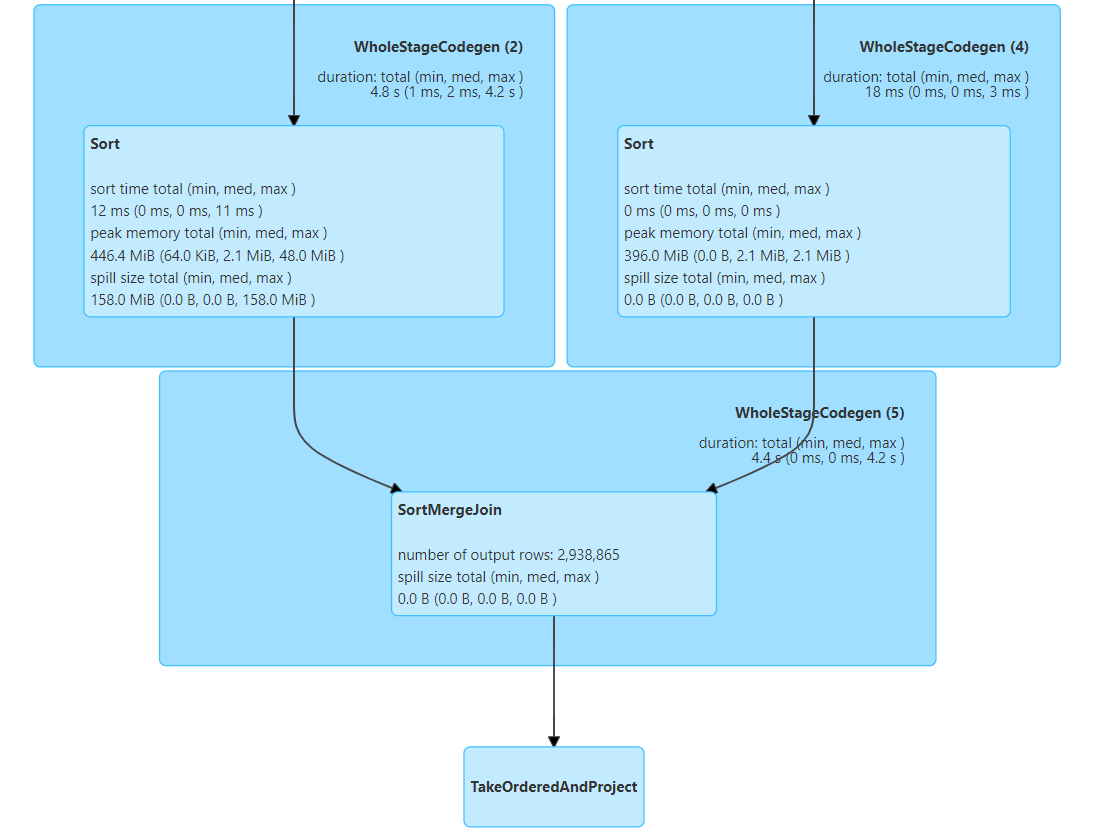 | 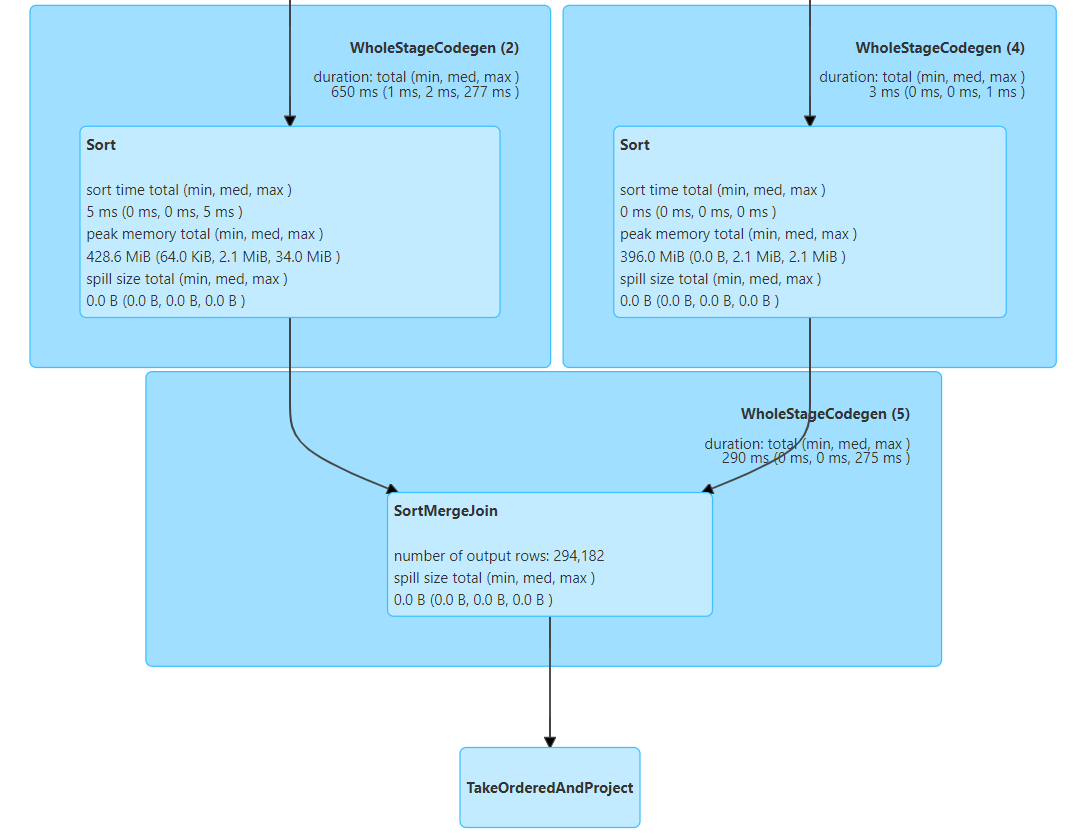|

# Задание 3

## Входные данные 

*cut_transactions.csv*  — информация о длительности просомтра контента пользователям

Описание фичей в cut_transactions.csv: 
1. user_uid — уникальный идентификатор пользователя
2.  element_uid — уникальный идентификатор контента
3.  watched_time — время просмотра в секундах

*cut_ratings.csv*  — информация об оценках, поставленных пользователями

Описание фичей в cut_ratings.csv: 
1. user_uid — уникальный идентификатор пользователя 
2. element_uid — уникальный идентификатор контента 
3. rating — поставленный пользователем рейтинг

*ids.csv*  — выборка пользователей
Описание фичей в ids.csv: 
1. user_uid — уникальный идентификатор пользователя 


## Что нужно сделать
Для каждого пользователя из выборки посчитать:
1. Максимальное и минимальное время просмотра фильмов с оценками 8, 9 и 10 
2. Название фичи должно быть в формате feat_агрегирующая_функция_watched_time_rating_оценка. 
3. Если у пользователь не ставил оценки 8, 9 и 10 то значение фичей должно быть null
4. Описать принятые при разработки кода решения и возможные оптимизации

P.S. На каждом этапе обработки должно быть должны агрегироваться минимально возможные объемы данных (сокращаем затраты на shuflle)

In [23]:
cut_transactions_df = spark.read.option('header', True).csv('s3a://input/cut_transactions.csv')
cut_ratings_df = spark.read.option('header', True).csv('s3a://input/cut_ratings.csv')
ids_df = spark.read.option('header', True).csv('s3a://input/ids.csv')

In [24]:
cut_transactions_df.show(2)

+-----------+--------+------------+
|element_uid|user_uid|watched_time|
+-----------+--------+------------+
|       6130|  563180|        3264|
|       2771|  133315|       10557|
+-----------+--------+------------+
only showing top 2 rows



In [25]:
cut_ratings_df.show(2)

+--------+-----------+------+
|user_uid|element_uid|rating|
+--------+-----------+------+
|  566386|        747|     9|
|   61690|       1415|     8|
+--------+-----------+------+
only showing top 2 rows



In [26]:
ids_df.show(2)

+--------+
|user_uid|
+--------+
|  207861|
|  355521|
+--------+
only showing top 2 rows



### Решение

In [27]:
top_ratings_df = cut_ratings_df.filter(cut_ratings_df['rating'].isin([8, 9, 10]))

transactions_ratings_df = cut_transactions_df.join(top_ratings_df, ['user_uid', 'element_uid'])

joined_df = transactions_ratings_df.join(ids_df, 'user_uid')

agg_df = joined_df.groupBy('user_uid', 'rating') \
    .agg(F.max(F.col('watched_time')).alias("max_watched_time"),
         F.min(F.col('watched_time')).alias("min_watched_time"))

In [28]:
result_df = agg_df.withColumn(
    'feat_max_watched_time_rating_8', F.when(F.col('rating') == 8, F.col('max_watched_time'))
).withColumn(
    'feat_min_watched_time_rating_8', F.when(F.col('rating') == 8, F.col('min_watched_time'))
).withColumn(
    'feat_max_watched_time_rating_9', F.when(F.col('rating') == 9, F.col('max_watched_time'))
).withColumn(
    'feat_min_watched_time_rating_9', F.when(F.col('rating') == 9, F.col('min_watched_time'))
).withColumn(
    'feat_max_watched_time_rating_10', F.when(F.col('rating') == 10, F.col('max_watched_time'))
).withColumn(
    'feat_min_watched_time_rating_10', F.when(F.col('rating') == 10, F.col('min_watched_time'))
)

# Выбор уникальных пользователей и финальных фичей
result = ids_df.join(result_df, 'user_uid', 'left_outer').select(
    'user_uid',
    'feat_max_watched_time_rating_8',
    'feat_min_watched_time_rating_8',
    'feat_max_watched_time_rating_9',
    'feat_min_watched_time_rating_9',
    'feat_max_watched_time_rating_10',
    'feat_min_watched_time_rating_10'
).distinct().orderBy('user_uid')


### Описание принятых решений и оптимизаций

- Фильтрация данных по рейтингам сразу после загрузки cut_ratings позволяет работать только с необходимыми данными.
 
- Джойн cut_transactions и отфильтрованных данных по рейтингам позволяет уменьшить объем данных перед объединением с ids

- Агрегируем данные, чтобы получить min и max время просмотра для каждого пользователя и оценки, что позволяет уменьшить количество данных для финального джойна.

При объединении больших датафреймов (в нашем случае транзакций и рейтингов), использование методов фильтрации и агрегации до джойна позволяет существенно сократить затраты на shuffle и улучшить производительность.

In [29]:
# Здесь необходимо вывести результат:
result.explain()
result.show(truncate=False)

== Physical Plan ==
*(13) Sort [user_uid#1205 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(user_uid#1205 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [plan_id=1797]
   +- *(12) HashAggregate(keys=[feat_max_watched_time_rating_8#1268, feat_min_watched_time_rating_10#1308, feat_min_watched_time_rating_8#1274, feat_min_watched_time_rating_9#1289, feat_max_watched_time_rating_10#1298, user_uid#1205, feat_max_watched_time_rating_9#1281], functions=[])
      +- *(12) HashAggregate(keys=[feat_max_watched_time_rating_8#1268, feat_min_watched_time_rating_10#1308, feat_min_watched_time_rating_8#1274, feat_min_watched_time_rating_9#1289, feat_max_watched_time_rating_10#1298, user_uid#1205, feat_max_watched_time_rating_9#1281], functions=[])
         +- *(12) Project [user_uid#1205, feat_max_watched_time_rating_8#1268, feat_min_watched_time_rating_8#1274, feat_max_watched_time_rating_9#1281, feat_min_watched_time_rating_9#1289, feat_max_watched_time_rating_10#1298, feat_min_watched_time_

+--------+------------------------------+------------------------------+------------------------------+------------------------------+-------------------------------+-------------------------------+
|user_uid|feat_max_watched_time_rating_8|feat_min_watched_time_rating_8|feat_max_watched_time_rating_9|feat_min_watched_time_rating_9|feat_max_watched_time_rating_10|feat_min_watched_time_rating_10|
+--------+------------------------------+------------------------------+------------------------------+------------------------------+-------------------------------+-------------------------------+
|11384   |NULL                          |NULL                          |NULL                          |NULL                          |7631                           |6797                           |
|126454  |NULL                          |NULL                          |NULL                          |NULL                          |34076                          |34076                          |
|1316